## Calibrate SABR and Displaced Diffusion models to swaption market data

### Note: This calibration programme also relies on an option pricer which a friend of mine wrote. I will not upload that pricer code in order to respect and protect my friend's work.

### The forward swap rates and discount factor data is also generated as another part of this group project, which is done by another team member. Thus I will also not upload the code to that part of this project as it is not originally done by me.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.optimize import least_squares

In [3]:
swaption = pd.read_excel('IR Data.xlsx', 'Swaption')

In [4]:
swaption

,Lognormal Implied Volatility for IR Swaptions,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NaN,NaN,Strike (Forward + basis point),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps
2,1Y,1Y,91.57,62.03,44.13,31.224,26.182,22.5,20.96,21.4,24.34,27.488,30.297
3,1Y,2Y,83.27,61.24,46.57,35.807,31.712,28.72,27.12,26.84,28.51,31.025,33.523
4,1Y,3Y,73.92,56.87,44.77,35.745,32.317,29.78,28.29,27.8,28.77,30.725,32.833
5,1Y,5Y,55.19,44.64,36.51,30.242,27.851,26.07,24.98,24.56,25.12,26.536,28.165
6,1Y,10Y,41.18,35.04,30.207,26.619,25.351,24.47,23.98,23.82,24.25,25.204,26.355
7,5Y,1Y,67.8,49.09,38.4,31.485,29.06,27.26,26.04,25.32,24.94,25.32,25.98
8,5Y,2Y,57.88,46.41,39.033,33.653,31.531,29.83,28.56,27.65,26.71,26.54,26.76
9,5Y,3Y,53.43,44.44,38.18,33.437,31.536,29.98,28.76,27.82,26.67,26.2,26.15


In [5]:
swaption1 = pd.DataFrame(swaption.loc[2:].values, columns=swaption.loc[1].values)

In [6]:
swaption1.set_index(['Expiry','Tenor'], inplace=True)

In [7]:
swaption1.columns

Index(['-200bps', '-150bps', '-100bps', '-50bps', '-25bps', 'ATM', '+25bps',
       '+50bps', '+100bps', '+150bps', '+200bps'],
      dtype='object')

In [8]:
rates = pd.read_csv('forward_swap_rate.csv')

In [9]:
rates.rename(columns={'Unnamed: 0':'Expiry/Tenor'}, inplace=True)

In [10]:
rates.set_index('Expiry/Tenor', inplace=True)

In [11]:
rates.columns = rates.columns.astype(int)

In [12]:
discount = pd.read_csv('discount_factor.csv')
discount.set_index('Tenor',inplace=True)

# Part 1: Displaced-Diffusion Model Calibration

In [13]:
def DDcalibration(expiry, tenor, trunc):
    
    df = swaption1.loc[f'{expiry}Y',f'{tenor}Y']
    df = df.to_frame().T
    
    ATM = rates.loc[expiry, tenor]
    
    strikes = [ATM-200/100/100, ATM-150/100/100, ATM-100/100/100, ATM-50/100/100, ATM-25/100/100,
             ATM,
             ATM+25/100/100, ATM+50/100/100, ATM+100/100/100, ATM+150/100/100, ATM+200/100/100]
    
    df = pd.DataFrame([list(df.values[0]), strikes],
            columns = df.columns,
            index = ['imvol', 'strike']).T
    
    df['imvol'] = df['imvol']/100
    
    
    df1 = df.copy()
    if trunc != 0:
        df1 = df1.iloc[trunc:-trunc]   
    
    
    ATMvol = df1.loc['ATM', 'imvol']
    F = df1.loc['ATM','strike']
    T = expiry

    def _displace(x, beta, a):
        return beta * x + (1 - beta) * a

    def sigma_black_scholes(F, K, sigma, T, A, beta):
        # Choi, J., Kwak, M., Tee, C. W., & Wang, Y. (2022).
        # A Black–Scholes user's guide to the Bachelier model.
        # Journal of Futures Markets, 42(5), 959-980.
        k = K / F
        k_d = _displace(K, beta, A) / _displace(F, beta, A)

        first_chunk = sigma * (_displace(F, beta, A) / F) * np.sqrt(k_d / k) * (
                    (1 + (np.log(k_d) ** 2) / 24) / (1 + (np.log(k) ** 2) / 24))
        second_chunk = 1 + (sigma ** 2) * ((_displace(F, beta, A) / F) ** 2) * (k_d / k) * (T / 24)
        third_chunk = 1 + (beta ** 2) * (sigma ** 2) * (T / 24)

        return first_chunk * second_chunk / third_chunk

    ################# Calibration of Beta  #################################################

    def ddcalibration(x, strikes, vols, F, T, A):
        err = 0.0
        for i,vol in enumerate(vols):                    
            err +=(vol - sigma_black_scholes(F, 
                                             strikes[i], 
                                             x[0], 
                                             T, 
                                             A, 
                                             x[1])
                  )**2
        return err

    initialGuess = [0.1, 0.5]
    res = least_squares(lambda x: ddcalibration(x,
                                                df1['strike'].values,
                                                df1['imvol'].values,
                                                F, T, F), initialGuess)
    sigma = res.x[0]
    beta = res.x[1]   
    
    return [sigma, beta]

In [14]:
sigma_df = pd.DataFrame(index = rates.index, columns = rates.columns)
beta_df = pd.DataFrame(index = rates.index, columns = rates.columns)

In [15]:
tenor = [1,2,3,5,10]
expiry = [1,5,10]
for i in expiry:
    for j in tenor:
        sigma_df.loc[i,j] = DDcalibration(i, j, 2)[0]
        beta_df.loc[i,j] = DDcalibration(i, j, 2)[1]

In [16]:
sigma_df

,1,2,3,5,10
Expiry/Tenor,,,,,
1,0.273836,0.319175,0.323115,0.277468,0.253844
5,0.283606,0.304417,0.302813,0.267938,0.245684
10,0.287772,0.291665,0.292054,0.265791,0.241722


In [17]:
beta_df

,1,2,3,5,10
Expiry/Tenor,,,,,
1,0.043252,0.08761,0.151694,0.302144,0.437574
5,0.273651,0.294699,0.320003,0.396868,0.4575
10,0.326865,0.34477,0.362141,0.40431,0.454816


# Part 2: SABR Model Calibration

In [18]:
def SABRcalibration(expiry, tenor):
    
    def SABR(F, K, T, alpha, beta, rho, nu):
        X = K
        # if K is at-the-money-forward
        # F represents F_0 in the formula above
        if abs(F - K) < 1e-12:
            numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
            numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
            numer3 = ((2 - 3*rho*rho)/24)*nu*nu
            VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
            sabrsigma = VolAtm
        else:
            z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
            zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
            numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
            numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
            numer3 = ((2 - 3*rho*rho)/24)*nu*nu
            numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
            denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
            denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
            denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
            sabrsigma = numer/denom

        return sabrsigma

    def sabrcalibration(x, strikes, vols, F, T):
        '''sum of squared errors using SABR model'''
        err = 0.0
        for i, vol in enumerate(vols):
            err += (vol - SABR(F, strikes[i], T,
                               x[0], beta, x[1], x[2]))**2

        return err
    
    df = swaption1.loc[f'{expiry}Y',f'{tenor}Y']
    df = df.to_frame().T
    
    ATM = rates.loc[expiry, tenor]
    
    strikes = [ATM-200/100/100, ATM-150/100/100, ATM-100/100/100, ATM-50/100/100, ATM-25/100/100,
             ATM,
             ATM+25/100/100, ATM+50/100/100, ATM+100/100/100, ATM+150/100/100, ATM+200/100/100]
    
    df = pd.DataFrame([list(df.values[0]), strikes],
            columns = df.columns,
            index = ['imvol', 'strike']).T
    
    df['imvol'] = df['imvol']/100
    
    F = df.loc['ATM','strike']
    T = expiry
    beta = 0.9 
    initialGuess = [0.1, -0.5, 0.5]

    res = least_squares(lambda x: sabrcalibration(x,
                                                  df['strike'],
                                                  df['imvol'],
                                                  F,
                                                  T),
                        initialGuess)
    # least_squares(function_giving_residuals, initial_guess)

    alpha = res.x[0]
    rho = res.x[1]
    nu = res.x[2]
    
    sabrvols = []
    for K in df['strike']:
        sabrvols.append(SABR(F, K, T, alpha, beta, rho, nu))
    
#     
    
    return [alpha, nu, rho, sabrvols]

In [19]:
alpha_df = pd.DataFrame(index = rates.index, columns = rates.columns)
nu_df = pd.DataFrame(index = rates.index, columns = rates.columns)
rho_df = pd.DataFrame(index = rates.index, columns = rates.columns)

In [20]:
sabrvol_df = pd.DataFrame(index = swaption1.index, columns = swaption1.columns)

In [21]:
tenor = [1,2,3,5,10]
expiry = [1,5,10]
for i in expiry:
    for j in tenor:
        alpha_df.loc[i,j] = SABRcalibration(i, j)[0]
        nu_df.loc[i,j] = SABRcalibration(i, j)[1]
        rho_df.loc[i,j] = SABRcalibration(i, j)[2]
        sabrvol_df.loc[f'{i}Y',f'{j}Y'] = SABRcalibration(i, j)[3]

In [22]:
alpha_df

,1,2,3,5,10
Expiry/Tenor,,,,,
1,0.145625,0.190266,0.203736,0.18662,0.180705
5,0.163645,0.198988,0.211776,0.195189,0.178987
10,0.173571,0.190715,0.201572,0.197155,0.182926


In [23]:
nu_df

,1,2,3,5,10
Expiry/Tenor,,,,,
1,1.932001,1.623343,1.375213,0.97751,0.642747
5,1.305405,1.051677,0.927205,0.651602,0.481307
10,0.987676,0.909426,0.852516,0.708877,0.558215


In [24]:
rho_df

,1,2,3,5,10
Expiry/Tenor,,,,,
1,-0.608593,-0.524965,-0.496192,-0.460114,-0.373725
5,-0.564991,-0.541047,-0.550725,-0.532454,-0.46091
10,-0.528921,-0.529168,-0.534135,-0.547332,-0.516757


In [25]:
sabrvol_df

-200bps   -150bps   -100bps    -50bps    -25bps       ATM  \
Expiry Tenor                                                               
1Y     1Y     0.832608    0.6376  0.480849  0.343856  0.280199  0.222692   
       2Y     0.785473  0.622706  0.491043  0.378747  0.329572  0.288168   
       3Y      0.70621    0.5717  0.463054  0.372142  0.333535  0.301605   
       5Y     0.534828  0.444504  0.371824  0.312491  0.288081  0.268124   
       10Y    0.400129  0.348793  0.308119  0.276461  0.264026  0.253983   
5Y     1Y     0.619203  0.511167   0.41808  0.335945  0.299322  0.267478   
       2Y     0.555297  0.473438  0.404033   0.34482  0.319312  0.297274   
       3Y     0.519701   0.44931  0.390181  0.340289  0.318883  0.300211   
       5Y     0.413282  0.365798  0.326442   0.29383   0.27997  0.267816   
       10Y    0.341605  0.309779  0.283754   0.26266   0.25385  0.246178   
10Y    1Y     0.528252  0.451999  0.386271  0.329585  0.305074  0.283954   
       2Y     0.498073  0.433158  0.377493  0.329971  0.309537  0.291794   
       3Y     0.473266   0.41651  0.367923  0.326594   0.30881  0.293234   
       5Y     0.401321  0.359222  0.323151  0.292455  0.279155  0.267331   
       10Y    0.332205  0.304909  0.281384  0.261349  0.252638  0.244824   

                +25bps    +50bps   +100bps   +150bps   +200bps  
Expiry Tenor                                                    
1Y     1Y     0.188875  0.194468  0.242066  0.290729  0.334349  
       2Y     0.261264  0.254471  0.278709   0.31559   0.35189  
       3Y      0.27963  0.270178  0.280443  0.306147  0.334256  
       5Y     0.253707  0.245553  0.245609   0.25793  0.274317  
       10Y    0.246408  0.241275    0.2375  0.240069  0.246238  
5Y     1Y      0.24379  0.232043  0.239642  0.263904  0.290789  
       2Y     0.279649  0.267387  0.259429  0.266896  0.281017  
       3Y     0.284736  0.272929  0.260926  0.261581  0.269404  
       5Y     0.257464  0.249003  0.237837  0.233569  0.234351  
       10Y    0.239635  0.234202  0.226511  0.222568  0.221574  
10Y    1Y     0.267261  0.256012  0.250122   0.25915  0.274291  
       2Y      0.27727   0.26648  0.256616  0.259162  0.268458  
       3Y     0.280179  0.269947  0.258402  0.257146  0.262476  
       5Y     0.257102  0.248589  0.236961  0.232096  0.232429  
       10Y    0.237932  0.231986  0.222959  0.217586  0.215352

In [26]:
swaption2 = swaption1/100

In [27]:
swaption2

-200bps  -150bps  -100bps   -50bps   -25bps     ATM  +25bps  \
Expiry Tenor                                                                
1Y     1Y      0.9157   0.6203   0.4413  0.31224  0.26182   0.225  0.2096   
       2Y      0.8327   0.6124   0.4657  0.35807  0.31712  0.2872  0.2712   
       3Y      0.7392   0.5687   0.4477  0.35745  0.32317  0.2978  0.2829   
       5Y      0.5519   0.4464   0.3651  0.30242  0.27851  0.2607  0.2498   
       10Y     0.4118   0.3504  0.30207  0.26619  0.25351  0.2447  0.2398   
5Y     1Y       0.678   0.4909    0.384  0.31485   0.2906  0.2726  0.2604   
       2Y      0.5788   0.4641  0.39033  0.33653  0.31531  0.2983  0.2856   
       3Y      0.5343   0.4444   0.3818  0.33437  0.31536  0.2998  0.2876   
       5Y      0.4199  0.36524  0.32326  0.29005  0.27677   0.266  0.2573   
       10Y    0.34417  0.30948  0.28148  0.25954  0.25136  0.2451  0.2399   
10Y    1Y      0.5516   0.4432  0.37368  0.32259   0.3021  0.2854  0.2731   
       2Y      0.5117    0.429  0.37078  0.32622    0.308  0.2928  0.2809   
       3Y      0.4822   0.4143    0.364  0.32439  0.30796   0.294  0.2827   
       5Y      0.4055  0.35891  0.32181  0.29144  0.27857  0.2674   0.258   
       10Y    0.33601  0.30509  0.27978  0.25926  0.25086  0.2437  0.2376   

              +50bps +100bps  +150bps  +200bps  
Expiry Tenor                                    
1Y     1Y      0.214  0.2434  0.27488  0.30297  
       2Y     0.2684  0.2851  0.31025  0.33523  
       3Y      0.278  0.2877  0.30725  0.32833  
       5Y     0.2456  0.2512  0.26536  0.28165  
       10Y    0.2382  0.2425  0.25204  0.26355  
5Y     1Y     0.2532  0.2494   0.2532   0.2598  
       2Y     0.2765  0.2671   0.2654   0.2676  
       3Y     0.2782  0.2667    0.262   0.2615  
       5Y     0.2502  0.2406   0.2357    0.234  
       10Y    0.2356  0.2291   0.2249   0.2225  
10Y    1Y     0.2645  0.2561   0.2552   0.2578  
       2Y      0.272  0.2612   0.2572   0.2571  
       3Y     0.2738  0.2618   0.2558   0.2537  
       5Y     0.2502  0.2387   0.2317    0.228  
       10Y    0.2324  0.2244    0.219   0.2156

<AxesSubplot: >

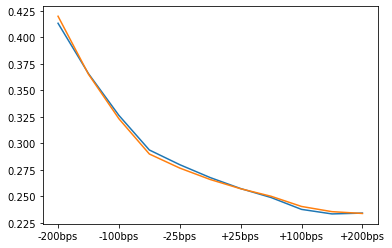

In [28]:
sabrvol_df.loc['5Y','5Y'].plot()
swaption2.loc['5Y','5Y'].plot()

In [29]:
# sabrvol_df.to_csv('sabrvol.csv')

In [30]:
# alpha_df.to_csv('alpha.csv')
# nu_df.to_csv('nu.csv')
# rho_df.to_csv('rho.csv')

# Part 3

In [31]:
def Black76Lognormal(F, K, sigma, T, payoff):
    d1 = (np.log(F/K)+(0.5*(sigma**2)*T))/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if payoff == 'payer': # payer swaption
        return F*norm.cdf(d1) - K*norm.cdf(d2)
    if payoff == 'receiver': # receiver swaption
        return K*norm.cdf(-d2) - F*norm.cdf(-d1)

def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    # F represents F_0 in the formula above
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [43]:
discount_factor

,df,df_l
Tenor,,
0.0,1.000000,1.000000
0.5,0.998752,0.987654
1.0,0.997009,0.972577
1.5,0.995270,0.957378
2.0,0.993531,0.942179
...,...,...
28.0,0.857941,0.260573
28.5,0.855307,0.251346
29.0,0.852674,0.242118


In [32]:
discount_factor = pd.read_csv('discount_factor.csv').iloc[:,1:].set_index('Tenor').drop('cumsum', axis=1)
discount_factor.loc[0] = [1,1]
discount_factor = discount_factor.sort_index()

def get_forward_rate(start, end):
    
    view_df = discount_factor.loc[start:end]
    
    ois = view_df['df']
    libor = view_df['df_l']
    
    pvbp = ois.iloc[1:].sum() * 0.5

    periodic_libor = (libor.shift(1) - libor)/libor
    floating_pv = periodic_libor * ois
    return floating_pv.sum()/(pvbp.sum())

## payer swaption 2y $\times$ 10y using SABR

In [33]:
### linear interpolation 2y x 10y by Linear Interpolation on alpha, nu and rho directly.
alpha2_10 = np.interp(2, [1,5], [alpha_df.loc[1,10], alpha_df.loc[5,10]])
rho2_10 = np.interp(2, [1,5], [rho_df.loc[1,10], rho_df.loc[5,10]])
nu2_10 = np.interp(2, [1,5], [nu_df.loc[1,10], nu_df.loc[5,10]])

### payer 2y x 10y
expiry2_10, tenor2_10 = 2, 10
pvbp2_10 = 0.5 * discount.loc[expiry2_10+0.5:expiry2_10+tenor2_10, 'df'].sum()
strikes = np.linspace(0.01, 0.08, 8)
F_sabr_2_10 = get_forward_rate(expiry2_10, expiry2_10+tenor2_10)
beta = 0.9
sabrpayer2_10 = []
for K in strikes:
    sabrvol2_10 = SABR(F_sabr_2_10, K, expiry2_10, alpha2_10, beta, rho2_10, nu2_10)

    sabrpayer2_10.append(pvbp2_10 * Black76Lognormal(F_sabr_2_10, K, sabrvol2_10, expiry2_10, payoff='payer'))

sabrpayer = pd.DataFrame(sabrpayer2_10, index = strikes, columns = ['Payer 2y x 10y'])

## payer swaption 2y $\times$ 10y using Displaced-Diffusion

In [34]:
def DisplacedDiffusion(F, K, beta, sigma, T, payoff):
    Fd = F/beta
    Kd = K + ((1-beta)/beta)*F
    sigma_d = sigma*beta
    
    d1 = (np.log(Fd/Kd) + (0.5*sigma_d**2)*T)/(sigma_d*np.sqrt(T))
    d2 = d1 - sigma_d*np.sqrt(T)
    
    if payoff == 'payer': 
        call_value = Fd*norm.cdf(d1) - Kd*norm.cdf(d2)
        return call_value
    
    elif payoff == 'receiver': 
        put_value = -Fd*norm.cdf(-d1) + Kd*norm.cdf(-d2)
        return put_value

In [35]:
beta2_10 = np.interp(2, [1,5], [beta_df.loc[1,10], beta_df.loc[5,10]])
sigma2_10 = np.interp(2, [1,5], [sigma_df.loc[1,10], sigma_df.loc[5,10]])

### payer 2y x 10y
expiry2_10, tenor2_10 = 2, 10
pvbp2_10 = 0.5 * discount.loc[expiry2_10+0.5:expiry2_10+tenor2_10, 'df'].sum()
strikes = np.linspace(0.01, 0.08, 8)
F_dd_2_10 = get_forward_rate(expiry2_10, expiry2_10+tenor2_10)
ddpayer2_10 = []
for K in strikes:
    ddpayer2_10.append(pvbp2_10 * DisplacedDiffusion(F_dd_2_10, K, beta2_10, sigma2_10, expiry2_10, payoff='payer'))

ddpayer = pd.DataFrame(ddpayer2_10, index = strikes, columns = ['Payer 2y x 10y'])

In [42]:
F_sabr_2_10

0.03963437677317174

In [37]:
pd.concat([sabrpayer,ddpayer], axis = 1)

,Payer 2y x 10y,Payer 2y x 10y
0.01,0.288990,0.287631
0.02,0.197457,0.193451
0.03,0.115149,0.111211
0.04,0.053002,0.052915
0.05,0.020494,0.020802
0.06,0.008625,0.006888
0.07,0.004385,0.001974
0.08,0.002599,0.000503


## receiver swaption 8y $\times$ 10y using SABR

In [38]:
### linear interpolation
alpha8_10 = np.interp(8, [5,10], [alpha_df.loc[5,10], alpha_df.loc[10,10]])
rho8_10 = np.interp(8, [5,10], [rho_df.loc[5,10], rho_df.loc[10,10]])
nu8_10 = np.interp(8, [5,10], [nu_df.loc[5,10], nu_df.loc[10,10]])

### receiver 8y x 10y
expiry8_10, tenor8_10 = 8, 10
pvbp8_10 = 0.5 * discount.loc[expiry8_10+0.5:expiry8_10+tenor8_10, 'df'].sum()
strikes = np.linspace(0.01, 0.08, 8)
F_sabr_8_10 = get_forward_rate(expiry8_10, expiry8_10+tenor8_10)
beta = 0.9
sabrrec8_10 = []
for K in strikes:
    sabrvol8_10 = SABR(F_sabr_8_10, K, expiry8_10, alpha8_10, beta, rho8_10, nu8_10)

    sabrrec8_10.append(pvbp8_10 * Black76Lognormal(F_sabr_8_10, K, sabrvol8_10, expiry8_10, payoff='receiver'))

sabrrec = pd.DataFrame(sabrrec8_10, index = strikes, columns = ['Receiver 8y x 10y'])

## receiver swaption 8y $\times$ 10y using Displaced-Diffusion

In [39]:
beta8_10 = np.interp(8, [5,10], [beta_df.loc[5,10], beta_df.loc[10,10]])
sigma8_10 = np.interp(8, [5,10], [sigma_df.loc[5,10], sigma_df.loc[10,10]])

### receiver 8y x 10y
expiry8_10, tenor8_10 = 8, 10
pvbp8_10 = 0.5 * discount.loc[expiry8_10+0.5:expiry8_10+tenor8_10, 'df'].sum()
strikes = np.linspace(0.01, 0.08, 8)
F_dd_8_10 = get_forward_rate(expiry8_10, expiry8_10+tenor8_10)
ddrec8_10 = []
for K in strikes:
    ddrec8_10.append(pvbp8_10 * DisplacedDiffusion(F_dd_8_10, K, beta8_10, sigma8_10, expiry8_10, payoff='receiver'))

ddrec = pd.DataFrame(ddrec8_10, index = strikes, columns = ['Receiver 8y x 10y'])

In [40]:
F_sabr_8_10

0.048711148942112044

In [41]:
pd.concat([sabrrec,ddrec], axis = 1)

,Receiver 8y x 10y,Receiver 8y x 10y
0.01,0.018248,0.008461
0.02,0.037244,0.022326
0.03,0.060167,0.046778
0.04,0.089778,0.083282
0.05,0.130233,0.131761
0.06,0.185817,0.191012
0.07,0.256376,0.259262
0.08,0.336972,0.334625
